# Wasserstein GAN implementation, training was interrupted.

Lsun data needs to be reshaped, different network structure & hyperparameters must be checked. FID calculation should be implemented.

There is very much to be done until the project delivery.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download jhoward/lsun_bedroom

100% 8.87G/8.89G [01:08<00:00, 153MB/s]
100% 8.89G/8.89G [01:08<00:00, 140MB/s]


In [ ]:
!ls

drive  kaggle.json  lsun_bedroom.zip  sample_data


In [2]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"

zip_file = pathToDrive+"savedGEN_wgan1_45.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_45.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
import zipfile
 
zip_file = "/content/lsun_bedroom.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Preparing dataset

In [ ]:
import glob
import cv2
import os

def load_images_from_folder_recursively(folder,from_ind, to_ind):
  images = []
  counter = 0
  for filename in glob.iglob(folder + '**/*.jpg', recursive=True):
    counter = counter + 1
    if(counter < from_ind):
          continue
    if(counter % to_ind == 0):
      break
    img = cv2.imread(filename)
    if img is not None:
      images.append(np.float32(cv2.resize(img, (64,64))))
    #print(filename)
    #break
  return images

In [5]:
IMG_SHAPE = (64, 64, 3)
BATCH_SIZE = 128
# Size of the noise vector
noise_dim = 128

# Discriminator

In [6]:
# DISCRiMINATOR

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    # x = conv_block(
    #     x,
    #     512,
    #     kernel_size=(5, 5),
    #     strides=(2, 2),
    #     use_bn=False,
    #     activation=layers.LeakyReLU(0.2),
    #     use_bias=True,
    #     use_dropout=False,
    #     drop_value=0.3,
    # )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 68, 68, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 34, 34, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 17, 17, 256)       0         
                                                     

# Generator

In [7]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(8 * 8 * 128 , use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((8, 8, 128))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        256,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    # x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 8192)              1048576   
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                       

# WGAN Monitor

In [8]:
gen_img_dir = "/content/gan1_images"

!mkdir /content/gan1_images

In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save(gen_img_dir + "/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


# WGAN-GP model

In [10]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


# Training the GAN model

In [11]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)

# update: CHANGING learning rate to 0.002
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 3

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=10, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.discriminator.compile(optimizer = discriminator_optimizer)
wgan.generator.compile(optimizer = generator_optimizer)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)



#Training

In [ ]:
# loading saved models, could be used to load saved models

gg = keras.models.load_model('savedGEN_wgan1_42')
dd = keras.models.load_model('savedDIS_wgan1_42')
wgan.discriminator = dd
wgan.generator = gg


## First epoch - by chunks of 1/8 of data

In [12]:
path_to_img_folder = "/content/data0/lsun/bedroom/"

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_1")
dis_to_save.save("savedDIS_wgan1_1")

Epoch 1/3
391/391 [==============================] - 530s 1s/step - d_loss: -12.4649 - g_loss: -2.4338
Epoch 2/3
391/391 [==============================] - 513s 1s/step - d_loss: -11.2126 - g_loss: -3.7886
Epoch 3/3
391/391 [==============================] - 513s 1s/step - d_loss: -9.4404 - g_loss: 0.2898
INFO:tensorflow:Assets written to: savedGEN_wgan1_1/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_1/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_2")
dis_to_save.save("savedDIS_wgan1_2")

Epoch 1/3
391/391 [==============================] - 516s 1s/step - d_loss: -8.2195 - g_loss: 4.6508
Epoch 2/3
391/391 [==============================] - 513s 1s/step - d_loss: -7.3273 - g_loss: -5.8272
Epoch 3/3
391/391 [==============================] - 513s 1s/step - d_loss: -6.9596 - g_loss: 1.5414
INFO:tensorflow:Assets written to: savedGEN_wgan1_2/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_2/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_3")
dis_to_save.save("savedDIS_wgan1_3")

Epoch 1/3
391/391 [==============================] - 511s 1s/step - d_loss: -6.6112 - g_loss: 6.2661
Epoch 2/3
391/391 [==============================] - 513s 1s/step - d_loss: -6.2261 - g_loss: -1.5932
Epoch 3/3
391/391 [==============================] - 514s 1s/step - d_loss: -5.9764 - g_loss: 1.9331
INFO:tensorflow:Assets written to: savedGEN_wgan1_3/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_3/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_4")
dis_to_save.save("savedDIS_wgan1_4")

Epoch 1/3
391/391 [==============================] - 511s 1s/step - d_loss: -5.7921 - g_loss: -6.4396
Epoch 2/3
391/391 [==============================] - 513s 1s/step - d_loss: -5.5483 - g_loss: -1.9196
Epoch 3/3
391/391 [==============================] - 513s 1s/step - d_loss: -5.4404 - g_loss: 1.0184
INFO:tensorflow:Assets written to: savedGEN_wgan1_4/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_4/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_5")
dis_to_save.save("savedDIS_wgan1_5")

Epoch 1/3
391/391 [==============================] - 513s 1s/step - d_loss: -5.4085 - g_loss: -1.7247
Epoch 2/3
391/391 [==============================] - 514s 1s/step - d_loss: -5.3857 - g_loss: -1.6159
Epoch 3/3
391/391 [==============================] - 514s 1s/step - d_loss: -5.3101 - g_loss: 1.7946
INFO:tensorflow:Assets written to: savedGEN_wgan1_5/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_5/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_6")
dis_to_save.save("savedDIS_wgan1_6")

Epoch 1/3
391/391 [==============================] - 513s 1s/step - d_loss: -5.1443 - g_loss: -5.2371
Epoch 2/3
391/391 [==============================] - 514s 1s/step - d_loss: -5.1120 - g_loss: -3.3106
Epoch 3/3
391/391 [==============================] - 514s 1s/step - d_loss: -4.8924 - g_loss: -0.0403
INFO:tensorflow:Assets written to: savedGEN_wgan1_6/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_6/assets


In [ ]:
!zip -r savedDIS_wgan1_6.zip savedDIS_wgan1_6/
!zip -r savedGEN_wgan1_6.zip savedGEN_wgan1_6/

  adding: savedDIS_wgan1_6/ (stored 0%)
  adding: savedDIS_wgan1_6/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_6/assets/ (stored 0%)
  adding: savedDIS_wgan1_6/variables/ (stored 0%)
  adding: savedDIS_wgan1_6/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_6/variables/variables.index (deflated 64%)
  adding: savedDIS_wgan1_6/keras_metadata.pb (deflated 91%)


# Epochs 4-5

In [ ]:
# training for additional 2 epochs
epochs = 2

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_7")
dis_to_save.save("savedDIS_wgan1_7")

Epoch 1/2
391/391 [==============================] - 512s 1s/step - d_loss: -4.9258 - g_loss: -2.5998
Epoch 2/2
391/391 [==============================] - 513s 1s/step - d_loss: -4.7425 - g_loss: 8.9179
INFO:tensorflow:Assets written to: savedGEN_wgan1_7/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_7/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_8")
dis_to_save.save("savedDIS_wgan1_8")

Epoch 1/2
391/391 [==============================] - 514s 1s/step - d_loss: -4.4664 - g_loss: -12.4200
Epoch 2/2
391/391 [==============================] - 514s 1s/step - d_loss: -4.5403 - g_loss: -6.0571
INFO:tensorflow:Assets written to: savedGEN_wgan1_8/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_8/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_9")
dis_to_save.save("savedDIS_wgan1_9")

Epoch 1/2
391/391 [==============================] - 515s 1s/step - d_loss: -4.3719 - g_loss: -4.9112
Epoch 2/2
391/391 [==============================] - 514s 1s/step - d_loss: -4.3816 - g_loss: -10.8381
INFO:tensorflow:Assets written to: savedGEN_wgan1_9/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_9/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_10")
dis_to_save.save("savedDIS_wgan1_10")

Epoch 1/2
391/391 [==============================] - 513s 1s/step - d_loss: -4.2876 - g_loss: 1.7029
Epoch 2/2
391/391 [==============================] - 513s 1s/step - d_loss: -4.0877 - g_loss: -5.6355
INFO:tensorflow:Assets written to: savedGEN_wgan1_10/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_10/assets


In [ ]:
!zip -r savedDIS_wgan1_10.zip savedDIS_wgan1_10/
!zip -r savedGEN_wgan1_10.zip savedGEN_wgan1_10/

  adding: savedDIS_wgan1_10/ (stored 0%)
  adding: savedDIS_wgan1_10/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_10/assets/ (stored 0%)
  adding: savedDIS_wgan1_10/variables/ (stored 0%)
  adding: savedDIS_wgan1_10/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedDIS_wgan1_10/variables/variables.index (deflated 64%)
  adding: savedDIS_wgan1_10/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_10/ (stored 0%)
  adding: savedGEN_wgan1_10/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_10/assets/ (stored 0%)
  adding: savedGEN_wgan1_10/variables/ (stored 0%)
  adding: savedGEN_wgan1_10/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_10/variables/variables.index (deflated 69%)
  adding: savedGEN_wgan1_10/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_11")
dis_to_save.save("savedDIS_wgan1_11")

Epoch 1/3
391/391 [==============================] - 525s 1s/step - d_loss: -4.4272 - g_loss: -8.4190
Epoch 2/3
391/391 [==============================] - 505s 1s/step - d_loss: -4.0248 - g_loss: -0.4992
Epoch 3/3
391/391 [==============================] - 506s 1s/step - d_loss: -4.2962 - g_loss: -1.6020
INFO:tensorflow:Assets written to: savedGEN_wgan1_11/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_11/assets


In [ ]:
# epochs = 2
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_12")
dis_to_save.save("savedDIS_wgan1_12")

Epoch 1/2
391/391 [==============================] - 508s 1s/step - d_loss: -4.3172 - g_loss: -9.6373
Epoch 2/2
391/391 [==============================] - 506s 1s/step - d_loss: -3.8445 - g_loss: -14.2747
INFO:tensorflow:Assets written to: savedGEN_wgan1_12/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_12/assets


# Epochs 6-7

In [ ]:
# training for additional 2 epochs
epochs = 2

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_13")
dis_to_save.save("savedDIS_wgan1_13")

Epoch 1/2
391/391 [==============================] - 564s 1s/step - d_loss: -4.3367 - g_loss: -9.0908
Epoch 2/2
391/391 [==============================] - 545s 1s/step - d_loss: -4.0609 - g_loss: -18.7945
INFO:tensorflow:Assets written to: savedGEN_wgan1_13/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_13/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_14")
dis_to_save.save("savedDIS_wgan1_14")

Epoch 1/2
391/391 [==============================] - 536s 1s/step - d_loss: -3.8164 - g_loss: 1.4660
Epoch 2/2
391/391 [==============================] - 545s 1s/step - d_loss: -3.8649 - g_loss: -15.1369
INFO:tensorflow:Assets written to: savedGEN_wgan1_14/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_14/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_15")
dis_to_save.save("savedDIS_wgan1_15")

Epoch 1/2
391/391 [==============================] - 533s 1s/step - d_loss: -3.8469 - g_loss: 7.9778
Epoch 2/2
391/391 [==============================] - 545s 1s/step - d_loss: -3.6486 - g_loss: 8.1259
INFO:tensorflow:Assets written to: savedGEN_wgan1_15/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_15/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_16")
dis_to_save.save("savedDIS_wgan1_16")

Epoch 1/2
391/391 [==============================] - 532s 1s/step - d_loss: -3.5442 - g_loss: 18.9114
Epoch 2/2
391/391 [==============================] - 544s 1s/step - d_loss: -3.4891 - g_loss: 6.5586
INFO:tensorflow:Assets written to: savedGEN_wgan1_16/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_16/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_17")
dis_to_save.save("savedDIS_wgan1_17")

Epoch 1/2
391/391 [==============================] - 534s 1s/step - d_loss: -3.4129 - g_loss: -7.4027
Epoch 2/2
391/391 [==============================] - 544s 1s/step - d_loss: -3.9327 - g_loss: 2.6845
INFO:tensorflow:Assets written to: savedGEN_wgan1_17/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_17/assets


In [ ]:
# epochs = 2
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_18")
dis_to_save.save("savedDIS_wgan1_18")

Epoch 1/2
391/391 [==============================] - 546s 1s/step - d_loss: -3.7523 - g_loss: 12.6241
Epoch 2/2
391/391 [==============================] - 545s 1s/step - d_loss: -3.2757 - g_loss: 6.0411
INFO:tensorflow:Assets written to: savedGEN_wgan1_18/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_18/assets


In [ ]:
!zip -r savedDIS_wgan1_12.zip savedDIS_wgan1_12/
!zip -r savedGEN_wgan1_12.zip savedGEN_wgan1_12/
!zip -r savedDIS_wgan1_18.zip savedDIS_wgan1_18/
!zip -r savedGEN_wgan1_18.zip savedGEN_wgan1_18/

  adding: savedDIS_wgan1_12/ (stored 0%)
  adding: savedDIS_wgan1_12/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_12/assets/ (stored 0%)
  adding: savedDIS_wgan1_12/variables/ (stored 0%)
  adding: savedDIS_wgan1_12/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_12/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_12/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_12/ (stored 0%)
  adding: savedGEN_wgan1_12/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_12/assets/ (stored 0%)
  adding: savedGEN_wgan1_12/variables/ (stored 0%)
  adding: savedGEN_wgan1_12/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_12/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_12/keras_metadata.pb (deflated 93%)
  adding: savedDIS_wgan1_18/ (stored 0%)
  adding: savedDIS_wgan1_18/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_18/assets/ (stored 0%)
  adding: savedDIS_wgan1_18/varia

# Epoch 8

In [ ]:
# training for additional 1 epoch
epochs = 1

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_19")
dis_to_save.save("savedDIS_wgan1_19")

391/391 [==============================] - 546s 1s/step - d_loss: -3.5528 - g_loss: 1.2536
INFO:tensorflow:Assets written to: savedGEN_wgan1_19/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_19/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_20")
dis_to_save.save("savedDIS_wgan1_20")

391/391 [==============================] - 545s 1s/step - d_loss: -3.4802 - g_loss: 0.7196
INFO:tensorflow:Assets written to: savedGEN_wgan1_20/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_20/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_21")
dis_to_save.save("savedDIS_wgan1_21")

391/391 [==============================] - 546s 1s/step - d_loss: -3.4757 - g_loss: 4.2755
INFO:tensorflow:Assets written to: savedGEN_wgan1_21/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_21/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_22")
dis_to_save.save("savedDIS_wgan1_22")

391/391 [==============================] - 545s 1s/step - d_loss: -3.6527 - g_loss: 0.1966
INFO:tensorflow:Assets written to: savedGEN_wgan1_22/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_22/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_23")
dis_to_save.save("savedDIS_wgan1_23")

391/391 [==============================] - 545s 1s/step - d_loss: -3.4163 - g_loss: 0.6410
INFO:tensorflow:Assets written to: savedGEN_wgan1_23/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_23/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_24")
dis_to_save.save("savedDIS_wgan1_24")

391/391 [==============================] - 545s 1s/step - d_loss: -3.5806 - g_loss: -3.8462
INFO:tensorflow:Assets written to: savedGEN_wgan1_24/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_24/assets


# Epochs 9-10

In [ ]:
# training for additional 2 epochs
epochs = 2

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_25")
dis_to_save.save("savedDIS_wgan1_25")

Epoch 1/2
391/391 [==============================] - 546s 1s/step - d_loss: -3.4481 - g_loss: 1.0878
Epoch 2/2
391/391 [==============================] - 545s 1s/step - d_loss: -3.7162 - g_loss: -19.6825
INFO:tensorflow:Assets written to: savedGEN_wgan1_25/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_25/assets


In [ ]:
!zip -r savedDIS_wgan1_25.zip savedDIS_wgan1_25/
!zip -r savedGEN_wgan1_25.zip savedGEN_wgan1_25/

  adding: savedDIS_wgan1_25/ (stored 0%)
  adding: savedDIS_wgan1_25/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_25/assets/ (stored 0%)
  adding: savedDIS_wgan1_25/variables/ (stored 0%)
  adding: savedDIS_wgan1_25/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_25/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_25/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_25/ (stored 0%)
  adding: savedGEN_wgan1_25/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_25/assets/ (stored 0%)
  adding: savedGEN_wgan1_25/variables/ (stored 0%)
  adding: savedGEN_wgan1_25/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_25/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_25/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_26")
dis_to_save.save("savedDIS_wgan1_26")

Epoch 1/2
391/391 [==============================] - 546s 1s/step - d_loss: -3.6277 - g_loss: -0.2696
Epoch 2/2
391/391 [==============================] - 544s 1s/step - d_loss: -3.5295 - g_loss: -4.9774
INFO:tensorflow:Assets written to: savedGEN_wgan1_26/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_26/assets


In [ ]:
!zip -r savedDIS_wgan1_26.zip savedDIS_wgan1_26/
!zip -r savedGEN_wgan1_26.zip savedGEN_wgan1_26/

  adding: savedDIS_wgan1_26/ (stored 0%)
  adding: savedDIS_wgan1_26/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_26/assets/ (stored 0%)
  adding: savedDIS_wgan1_26/variables/ (stored 0%)
  adding: savedDIS_wgan1_26/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_26/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_26/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_26/ (stored 0%)
  adding: savedGEN_wgan1_26/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan1_26/assets/ (stored 0%)
  adding: savedGEN_wgan1_26/variables/ (stored 0%)
  adding: savedGEN_wgan1_26/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_26/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_26/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_27")
dis_to_save.save("savedDIS_wgan1_27")

Epoch 1/2
391/391 [==============================] - 606s 2s/step - d_loss: -3.3046 - g_loss: -8.6934
Epoch 2/2
391/391 [==============================] - 586s 1s/step - d_loss: -3.4493 - g_loss: -6.5637
INFO:tensorflow:Assets written to: savedGEN_wgan1_27/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_27/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_28")
dis_to_save.save("savedDIS_wgan1_28")

Epoch 1/2
391/391 [==============================] - 588s 2s/step - d_loss: -3.4819 - g_loss: -8.6338
Epoch 2/2
391/391 [==============================] - 586s 1s/step - d_loss: -2.9559 - g_loss: -10.5870
INFO:tensorflow:Assets written to: savedGEN_wgan1_28/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_28/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_29")
dis_to_save.save("savedDIS_wgan1_29")

Epoch 1/2
391/391 [==============================] - 587s 2s/step - d_loss: -3.4041 - g_loss: -7.3884
Epoch 2/2
391/391 [==============================] - 586s 1s/step - d_loss: -3.3836 - g_loss: 2.8227
INFO:tensorflow:Assets written to: savedGEN_wgan1_29/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_29/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_30")
dis_to_save.save("savedDIS_wgan1_30")

Epoch 1/2
391/391 [==============================] - 587s 2s/step - d_loss: -2.8657 - g_loss: 5.8372
Epoch 2/2
391/391 [==============================] - 586s 1s/step - d_loss: -3.2788 - g_loss: 8.2031
INFO:tensorflow:Assets written to: savedGEN_wgan1_30/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_30/assets



# Epochs 11-14

In [ ]:
# training for additional 4 epochs
epochs = 4

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_31")
dis_to_save.save("savedDIS_wgan1_31")

Epoch 1/4
391/391 [==============================] - 544s 1s/step - d_loss: -3.3232 - g_loss: 4.0918
Epoch 2/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.2128 - g_loss: 3.6253
Epoch 3/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.1276 - g_loss: 17.6571
Epoch 4/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.8123 - g_loss: 27.7471
INFO:tensorflow:Assets written to: savedGEN_wgan1_31/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_31/assets


In [ ]:
!zip -r savedDIS_wgan1_25.zip savedDIS_wgan1_25/
!zip -r savedGEN_wgan1_25.zip savedGEN_wgan1_25/

  adding: savedDIS_wgan1_25/ (stored 0%)
  adding: savedDIS_wgan1_25/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_25/assets/ (stored 0%)
  adding: savedDIS_wgan1_25/variables/ (stored 0%)
  adding: savedDIS_wgan1_25/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_25/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_25/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_25/ (stored 0%)
  adding: savedGEN_wgan1_25/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_25/assets/ (stored 0%)
  adding: savedGEN_wgan1_25/variables/ (stored 0%)
  adding: savedGEN_wgan1_25/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_25/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_25/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_32")
dis_to_save.save("savedDIS_wgan1_32")

Epoch 1/4
391/391 [==============================] - 525s 1s/step - d_loss: -2.2075 - g_loss: 36.2130
Epoch 2/4
391/391 [==============================] - 522s 1s/step - d_loss: -2.6310 - g_loss: 47.2345
Epoch 3/4
391/391 [==============================] - 522s 1s/step - d_loss: -3.1644 - g_loss: 19.0818
Epoch 4/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.4576 - g_loss: 7.6589
INFO:tensorflow:Assets written to: savedGEN_wgan1_32/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_32/assets


In [ ]:
!zip -r savedDIS_wgan1_32.zip savedDIS_wgan1_32/
!zip -r savedGEN_wgan1_32.zip savedGEN_wgan1_32/

  adding: savedDIS_wgan1_32/ (stored 0%)
  adding: savedDIS_wgan1_32/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_32/assets/ (stored 0%)
  adding: savedDIS_wgan1_32/variables/ (stored 0%)
  adding: savedDIS_wgan1_32/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_32/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_32/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_32/ (stored 0%)
  adding: savedGEN_wgan1_32/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan1_32/assets/ (stored 0%)
  adding: savedGEN_wgan1_32/variables/ (stored 0%)
  adding: savedGEN_wgan1_32/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_32/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_32/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_33")
dis_to_save.save("savedDIS_wgan1_33")

Epoch 1/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.1327 - g_loss: 17.9703
Epoch 2/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.2214 - g_loss: 18.0725
Epoch 3/4
391/391 [==============================] - 524s 1s/step - d_loss: -2.9618 - g_loss: 28.2582
Epoch 4/4
391/391 [==============================] - 523s 1s/step - d_loss: -3.6760 - g_loss: 19.6943
INFO:tensorflow:Assets written to: savedGEN_wgan1_33/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_33/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_34")
dis_to_save.save("savedDIS_wgan1_34")

Epoch 1/3
391/391 [==============================] - 548s 1s/step - d_loss: -2.4073 - g_loss: 9.7577
Epoch 2/3
391/391 [==============================] - 529s 1s/step - d_loss: -3.5410 - g_loss: -10.4612
Epoch 3/3
391/391 [==============================] - 528s 1s/step - d_loss: -3.2410 - g_loss: -11.7845
INFO:tensorflow:Assets written to: savedGEN_wgan1_34/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_34/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_35")
dis_to_save.save("savedDIS_wgan1_35")

Epoch 1/4
391/391 [==============================] - 529s 1s/step - d_loss: -2.9442 - g_loss: 2.3702
Epoch 2/4
391/391 [==============================] - 530s 1s/step - d_loss: -3.1861 - g_loss: 6.5451
Epoch 3/4
391/391 [==============================] - 529s 1s/step - d_loss: -3.6054 - g_loss: 8.6549
Epoch 4/4
391/391 [==============================] - 530s 1s/step - d_loss: -2.5429 - g_loss: 8.5572
INFO:tensorflow:Assets written to: savedGEN_wgan1_35/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_35/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_36")
dis_to_save.save("savedDIS_wgan1_36")

Epoch 1/4
391/391 [==============================] - 504s 1s/step - d_loss: -2.9770 - g_loss: 16.1250
Epoch 2/4
391/391 [==============================] - 491s 1s/step - d_loss: -2.9142 - g_loss: 13.9675
Epoch 3/4
391/391 [==============================] - 491s 1s/step - d_loss: -3.2887 - g_loss: 21.3266
Epoch 4/4
391/391 [==============================] - 491s 1s/step - d_loss: -3.4130 - g_loss: 5.1924
INFO:tensorflow:Assets written to: savedGEN_wgan1_36/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_36/assets


In [ ]:
!zip -r savedDIS_wgan1_34.zip savedDIS_wgan1_34/
!zip -r savedGEN_wgan1_34.zip savedGEN_wgan1_34/

!zip -r savedDIS_wgan1_36.zip savedDIS_wgan1_36/
!zip -r savedGEN_wgan1_36.zip savedGEN_wgan1_36/

  adding: savedDIS_wgan1_34/ (stored 0%)
  adding: savedDIS_wgan1_34/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_34/assets/ (stored 0%)
  adding: savedDIS_wgan1_34/variables/ (stored 0%)
  adding: savedDIS_wgan1_34/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_34/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_34/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_34/ (stored 0%)
  adding: savedGEN_wgan1_34/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan1_34/assets/ (stored 0%)
  adding: savedGEN_wgan1_34/variables/ (stored 0%)
  adding: savedGEN_wgan1_34/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_34/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_34/keras_metadata.pb (deflated 93%)
  adding: savedDIS_wgan1_36/ (stored 0%)
  adding: savedDIS_wgan1_36/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_36/assets/ (stored 0%)
  adding: savedDIS_wgan1_36/varia


# Epoch 15 - learning rate = 0.05 (very bad results) / later lr = 0.002 (bad results) / later lr = 0.00002 (better FID obtained)

In [ ]:
# training for additional 4 epochs
epochs = 1

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_37")
dis_to_save.save("savedDIS_wgan1_37")

391/391 [==============================] - 523s 1s/step - d_loss: 13886651820.1289 - g_loss: -9039.2824
INFO:tensorflow:Assets written to: savedGEN_wgan1_37/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_37/assets


In [ ]:
!zip -r savedDIS_wgan1_37.zip savedDIS_wgan1_37/
!zip -r savedGEN_wgan1_37.zip savedGEN_wgan1_37/

  adding: savedDIS_wgan1_37/ (stored 0%)
  adding: savedDIS_wgan1_37/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_37/assets/ (stored 0%)
  adding: savedDIS_wgan1_37/variables/ (stored 0%)
  adding: savedDIS_wgan1_37/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_37/variables/variables.index (deflated 52%)
  adding: savedDIS_wgan1_37/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_37/ (stored 0%)
  adding: savedGEN_wgan1_37/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan1_37/assets/ (stored 0%)
  adding: savedGEN_wgan1_37/variables/ (stored 0%)
  adding: savedGEN_wgan1_37/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_37/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_37/keras_metadata.pb (deflated 93%)


In [ ]:
# learning rate = 0.002, (------ STARTING FROM wgan1_36 ------)
epochs = 1
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_38")
dis_to_save.save("savedDIS_wgan1_38")

391/391 [==============================] - 543s 1s/step - d_loss: -1.7030 - g_loss: 24.9478
INFO:tensorflow:Assets written to: savedGEN_wgan1_38/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_38/assets


In [ ]:
!zip -r savedDIS_wgan1_38.zip savedDIS_wgan1_38/
!zip -r savedGEN_wgan1_38.zip savedGEN_wgan1_38/

  adding: savedDIS_wgan1_38/ (stored 0%)
  adding: savedDIS_wgan1_38/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_38/assets/ (stored 0%)
  adding: savedDIS_wgan1_38/variables/ (stored 0%)
  adding: savedDIS_wgan1_38/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_38/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_38/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_38/ (stored 0%)
  adding: savedGEN_wgan1_38/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan1_38/assets/ (stored 0%)
  adding: savedGEN_wgan1_38/variables/ (stored 0%)
  adding: savedGEN_wgan1_38/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_38/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_38/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_39")
dis_to_save.save("savedDIS_wgan1_39")

Epoch 1/3
391/391 [==============================] - 538s 1s/step - d_loss: 0.0685 - g_loss: 7.4714
Epoch 2/3
391/391 [==============================] - 519s 1s/step - d_loss: -1.4722 - g_loss: -13.2811
Epoch 3/3
391/391 [==============================] - 520s 1s/step - d_loss: 2.3217 - g_loss: 7.8779
INFO:tensorflow:Assets written to: savedGEN_wgan1_39/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_39/assets


In [ ]:
!zip -r savedDIS_wgan1_39.zip savedDIS_wgan1_39/
!zip -r savedGEN_wgan1_39.zip savedGEN_wgan1_39/

  adding: savedDIS_wgan1_39/ (stored 0%)
  adding: savedDIS_wgan1_39/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_39/assets/ (stored 0%)
  adding: savedDIS_wgan1_39/variables/ (stored 0%)
  adding: savedDIS_wgan1_39/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan1_39/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_39/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_39/ (stored 0%)
  adding: savedGEN_wgan1_39/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_39/assets/ (stored 0%)
  adding: savedGEN_wgan1_39/variables/ (stored 0%)
  adding: savedGEN_wgan1_39/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedGEN_wgan1_39/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_39/keras_metadata.pb (deflated 93%)


In [ ]:
# learning rate LOWER (lr = 0.00005 instead of 0.0002)

indeksior = 200000
epochs = 1


aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_40")
dis_to_save.save("savedDIS_wgan1_40")

391/391 [==============================] - 521s 1s/step - d_loss: -3.2307 - g_loss: 0.4092
INFO:tensorflow:Assets written to: savedGEN_wgan1_40/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_40/assets


In [ ]:
!zip -r savedDIS_wgan1_40.zip savedDIS_wgan1_40/
!zip -r savedGEN_wgan1_40.zip savedGEN_wgan1_40/

  adding: savedDIS_wgan1_40/ (stored 0%)
  adding: savedDIS_wgan1_40/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_40/assets/ (stored 0%)
  adding: savedDIS_wgan1_40/variables/ (stored 0%)
  adding: savedDIS_wgan1_40/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_40/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_40/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_40/ (stored 0%)
  adding: savedGEN_wgan1_40/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_40/assets/ (stored 0%)
  adding: savedGEN_wgan1_40/variables/ (stored 0%)
  adding: savedGEN_wgan1_40/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_40/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_40/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_41")
dis_to_save.save("savedDIS_wgan1_41")

391/391 [==============================] - 501s 1s/step - d_loss: -2.0901 - g_loss: -4.8029
INFO:tensorflow:Assets written to: savedGEN_wgan1_41/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_41/assets


In [ ]:
!zip -r savedDIS_wgan1_41.zip savedDIS_wgan1_41/
!zip -r savedGEN_wgan1_41.zip savedGEN_wgan1_41/

  adding: savedDIS_wgan1_41/ (stored 0%)
  adding: savedDIS_wgan1_41/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_41/assets/ (stored 0%)
  adding: savedDIS_wgan1_41/variables/ (stored 0%)
  adding: savedDIS_wgan1_41/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_41/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_41/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_41/ (stored 0%)
  adding: savedGEN_wgan1_41/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_41/assets/ (stored 0%)
  adding: savedGEN_wgan1_41/variables/ (stored 0%)
  adding: savedGEN_wgan1_41/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_41/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_41/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_42")
dis_to_save.save("savedDIS_wgan1_42")

391/391 [==============================] - 501s 1s/step - d_loss: -2.7723 - g_loss: -10.0320
INFO:tensorflow:Assets written to: savedGEN_wgan1_42/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_42/assets


In [ ]:
!zip -r savedDIS_wgan1_42.zip savedDIS_wgan1_42/
!zip -r savedGEN_wgan1_42.zip savedGEN_wgan1_42/


  adding: savedDIS_wgan1_42/ (stored 0%)
  adding: savedDIS_wgan1_42/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_42/assets/ (stored 0%)
  adding: savedDIS_wgan1_42/variables/ (stored 0%)
  adding: savedDIS_wgan1_42/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_42/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_42/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_42/ (stored 0%)
  adding: savedGEN_wgan1_42/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_42/assets/ (stored 0%)
  adding: savedGEN_wgan1_42/variables/ (stored 0%)
  adding: savedGEN_wgan1_42/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_42/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_42/keras_metadata.pb (deflated 93%)


In [ ]:
# learning rate LOWER (lr = 0.00002 instead of 0.0002)

indeksior = 200000
epochs = 1


aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_43")
dis_to_save.save("savedDIS_wgan1_43")

391/391 [==============================] - 507s 1s/step - d_loss: -2.8474 - g_loss: -13.4911
INFO:tensorflow:Assets written to: savedGEN_wgan1_43/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_43/assets


In [ ]:
!zip -r savedDIS_wgan1_43.zip savedDIS_wgan1_43/
!zip -r savedGEN_wgan1_43.zip savedGEN_wgan1_43/

  adding: savedDIS_wgan1_43/ (stored 0%)
  adding: savedDIS_wgan1_43/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_43/assets/ (stored 0%)
  adding: savedDIS_wgan1_43/variables/ (stored 0%)
  adding: savedDIS_wgan1_43/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_43/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_43/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_43/ (stored 0%)
  adding: savedGEN_wgan1_43/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_43/assets/ (stored 0%)
  adding: savedGEN_wgan1_43/variables/ (stored 0%)
  adding: savedGEN_wgan1_43/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_43/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_43/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_44")
dis_to_save.save("savedDIS_wgan1_44")

391/391 [==============================] - 501s 1s/step - d_loss: -3.2760 - g_loss: -13.6086
INFO:tensorflow:Assets written to: savedGEN_wgan1_44/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_44/assets


In [ ]:
!zip -r savedDIS_wgan1_44.zip savedDIS_wgan1_44/
!zip -r savedGEN_wgan1_44.zip savedGEN_wgan1_44/

  adding: savedDIS_wgan1_44/ (stored 0%)
  adding: savedDIS_wgan1_44/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_44/assets/ (stored 0%)
  adding: savedDIS_wgan1_44/variables/ (stored 0%)
  adding: savedDIS_wgan1_44/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_44/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_44/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_44/ (stored 0%)
  adding: savedGEN_wgan1_44/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_44/assets/ (stored 0%)
  adding: savedGEN_wgan1_44/variables/ (stored 0%)
  adding: savedGEN_wgan1_44/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_44/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_44/keras_metadata.pb (deflated 93%)


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan1_45")
dis_to_save.save("savedDIS_wgan1_45")

391/391 [==============================] - 501s 1s/step - d_loss: -2.7962 - g_loss: -14.6171
INFO:tensorflow:Assets written to: savedGEN_wgan1_45/assets
INFO:tensorflow:Assets written to: savedDIS_wgan1_45/assets


In [ ]:
!zip -r savedDIS_wgan1_45.zip savedDIS_wgan1_45/
!zip -r savedGEN_wgan1_45.zip savedGEN_wgan1_45/


  adding: savedDIS_wgan1_45/ (stored 0%)
  adding: savedDIS_wgan1_45/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan1_45/assets/ (stored 0%)
  adding: savedDIS_wgan1_45/variables/ (stored 0%)
  adding: savedDIS_wgan1_45/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: savedDIS_wgan1_45/variables/variables.index (deflated 51%)
  adding: savedDIS_wgan1_45/keras_metadata.pb (deflated 91%)
  adding: savedGEN_wgan1_45/ (stored 0%)
  adding: savedGEN_wgan1_45/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan1_45/assets/ (stored 0%)
  adding: savedGEN_wgan1_45/variables/ (stored 0%)
  adding: savedGEN_wgan1_45/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan1_45/variables/variables.index (deflated 62%)
  adding: savedGEN_wgan1_45/keras_metadata.pb (deflated 93%)


# FID calculations

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

# FID for the WGAN_36

In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
# training for additional 1 epoch
epochs = 1

In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

# Continue training the model.
wgan.fit(real_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


79/79 [==============================] - 122s 1s/step - d_loss: -0.6477 - g_loss: 1.8437


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID (different): %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID (different): 196.282


# FID for the WGAN_34




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_34.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_34.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_34')
dd = keras.models.load_model('savedDIS_wgan1_34')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

# Continue training the model.
wgan.fit(real_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


79/79 [==============================] - 115s 1s/step - d_loss: -2.3930 - g_loss: 19.0538


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 213.603


# FID for the WGAN_32




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_32.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_32.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_32')
dd = keras.models.load_model('savedDIS_wgan1_32')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
indeksior = 200000


real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

 # Continue training the model.
wgan.fit(real_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


79/79 [==============================] - 106s 1s/step - d_loss: 0.4158 - g_loss: 0.1194


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 218.814


# FID for the WGAN_26




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_26.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_26.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_26')
dd = keras.models.load_model('savedDIS_wgan1_26')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

# Continue training the model.
wgan.fit(real_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


79/79 [==============================] - 115s 1s/step - d_loss: -2.8254 - g_loss: 10.4113


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 228.225


# FID for the WGAN_25




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_25.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_25.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_25')
dd = keras.models.load_model('savedDIS_wgan1_25')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
#real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 209.580


# FID for the WGAN_18




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_18.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_18.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_18')
dd = keras.models.load_model('savedDIS_wgan1_18')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
#real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 227.399


# FID for the WGAN_12




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_12.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_12.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_12')
dd = keras.models.load_model('savedDIS_wgan1_12')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
#real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 246.968


# FID for the WGAN_10




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_10.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_10.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_10')
dd = keras.models.load_model('savedDIS_wgan1_10')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
#real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 251.593


# FID for the WGAN_6




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_6.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_6.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_6')
dd = keras.models.load_model('savedDIS_wgan1_6')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
#real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 339.484


# FID for the WGAN_37 (lr = 0.05 instead of 0.0002)




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_37.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_37.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_37')
dd = keras.models.load_model('savedDIS_wgan1_37')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 1305.331


# FID for the WGAN_38 (lr = 0.002 instead of 0.0002)




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_38.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_38.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_38')
dd = keras.models.load_model('savedDIS_wgan1_38')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 700.595


# FID for the WGAN_39 (lr = 0.002 instead of 0.0002) - additional training considered




In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_39.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_39.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_39')
dd = keras.models.load_model('savedDIS_wgan1_39')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 812.151


# FID for the WGAN_40 (lr = 0.00002 instead of 0.0002) - additional training considered

starting point: WGAN_36




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_40.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_40.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_40')
dd = keras.models.load_model('savedDIS_wgan1_40')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 174.551


# FID for the WGAN_41 (lr = 0.00002 instead of 0.0002) - additional training considered

starting point: WGAN_36




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_41.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_41.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_41')
dd = keras.models.load_model('savedDIS_wgan1_41')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 176.193


# FID for the WGAN_42 (lr = 0.00002 instead of 0.0002) - additional training considered

starting point: WGAN_36




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_42.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_42.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_42')
dd = keras.models.load_model('savedDIS_wgan1_42')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 177.403


# FID for the WGAN_43 (lr = 0.00002 instead of 0.0002) - additional training considered

starting point: WGAN_42




In [22]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(100, 1024)
            )

In [19]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan2_12.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan2_12.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Invalid file


In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

In [20]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan2_12')
# dd = keras.models.load_model('savedDIS_wgan2_12')
# wgan.discriminator = dd
wgan.generator = gg


In [23]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Text(0.5, 1.0, 'WGAN-GP training')

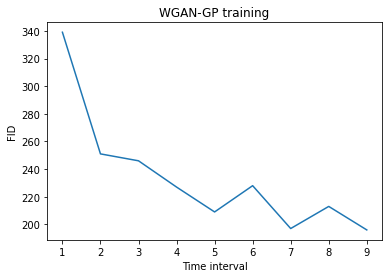

In [ ]:
# quick plot

from matplotlib import pyplot as plt

import seaborn as sns

y = [339,251,246,227,209,228,197,213,196]
x = [1,2,3,4,5,6,7,8,9]

ax = sns.lineplot(x = x, y = y)

ax.set_ylabel('FID')

ax.set_xlabel('Time interval')

ax.set_title("WGAN-GP training")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


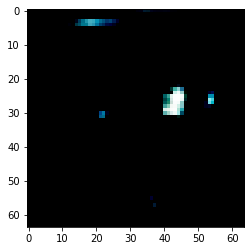

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


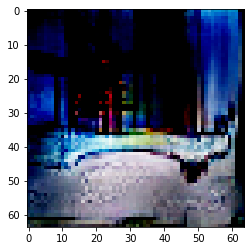

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


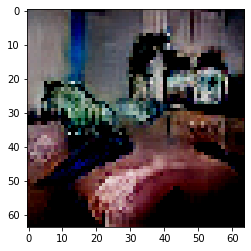

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


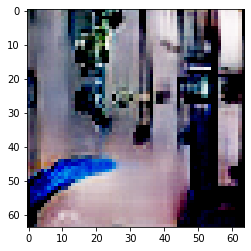

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


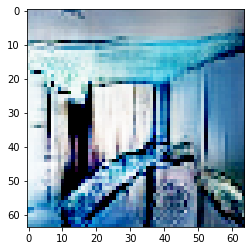

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


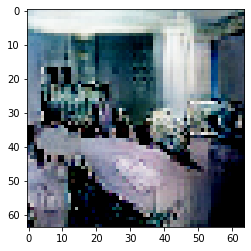

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


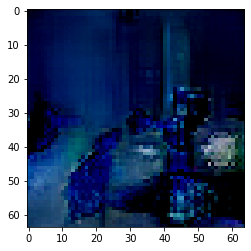

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


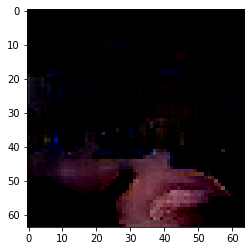

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


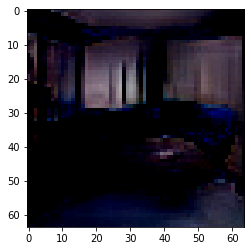

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


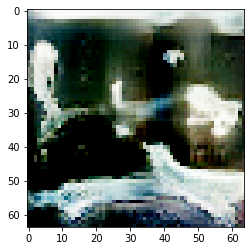

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


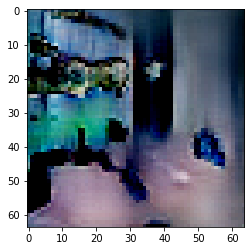

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


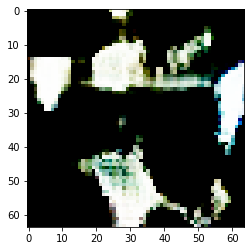

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


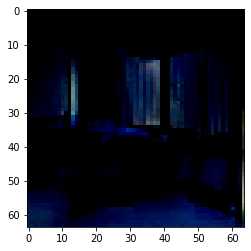

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


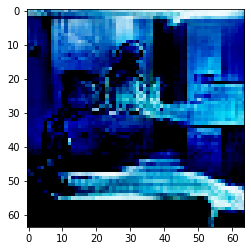

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14


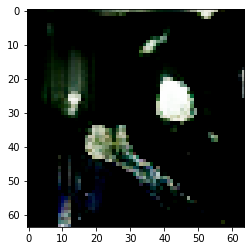

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


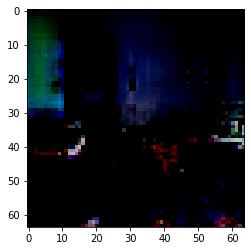

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16


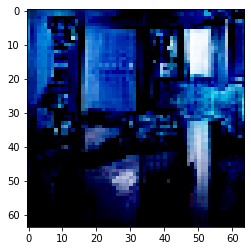

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


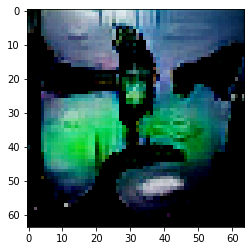

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


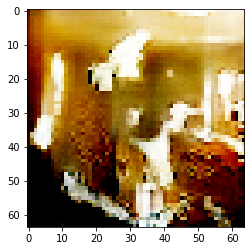

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


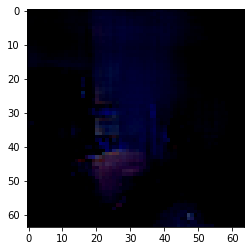

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


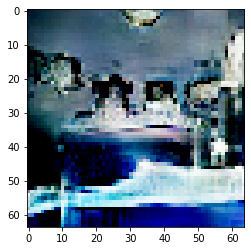

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


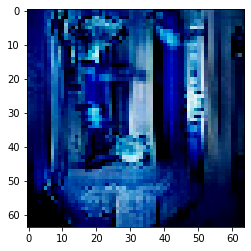

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


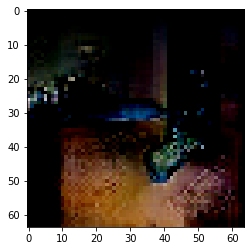

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23


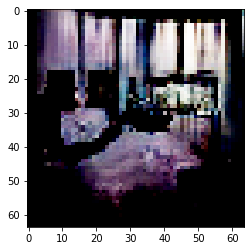

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24


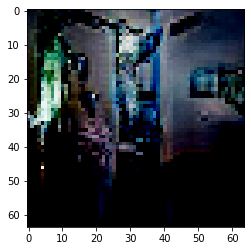

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


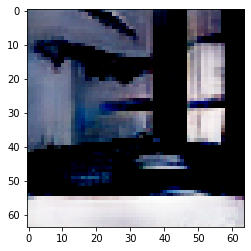

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26


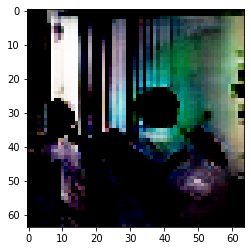

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27


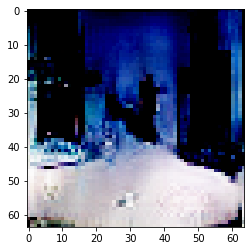

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28


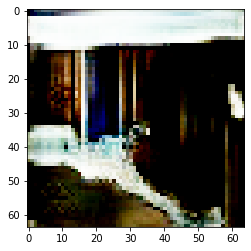

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29


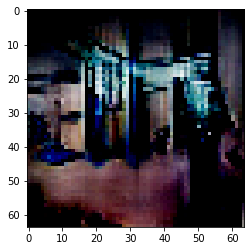

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


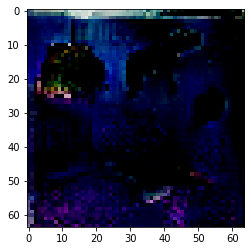

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31


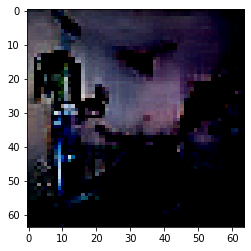

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


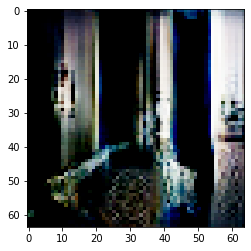

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33


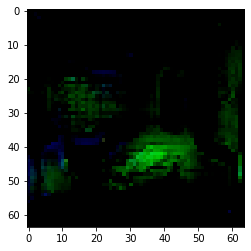

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


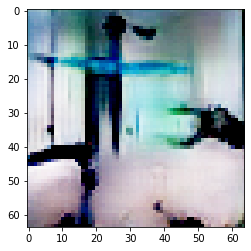

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35


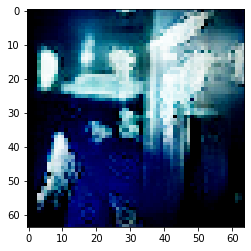

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36


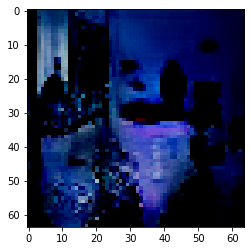

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37


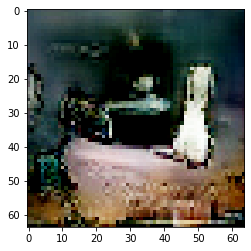

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38


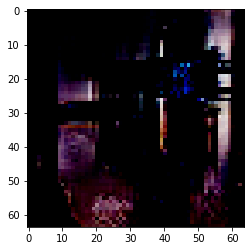

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39


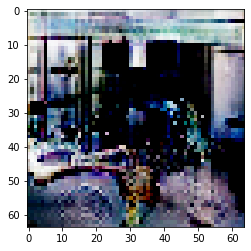

In [18]:
# wgan-45 images
from matplotlib import pyplot as plt

for i in range(40):
  plt.imshow(fake_images[i], interpolation='nearest')
  print(i)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


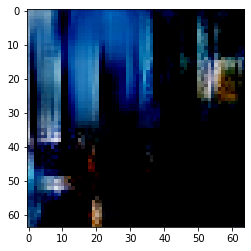

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


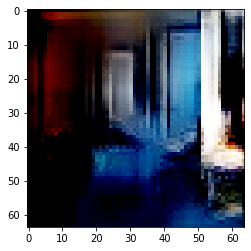

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


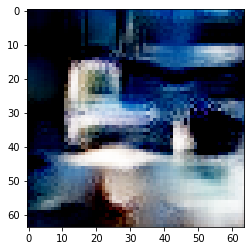

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


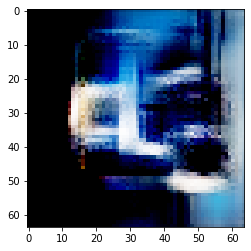

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


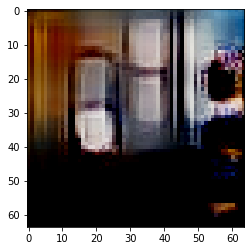

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


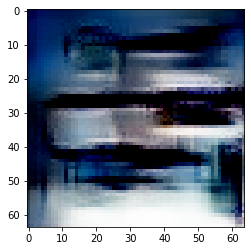

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


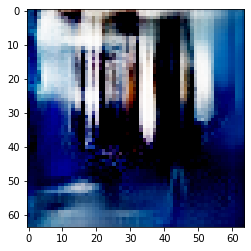

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


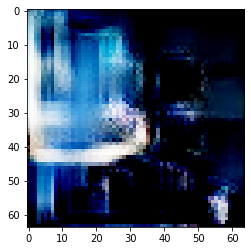

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


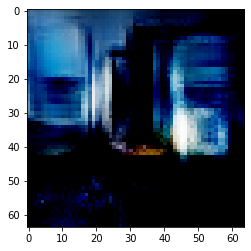

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


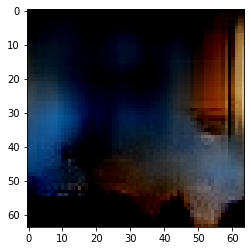

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


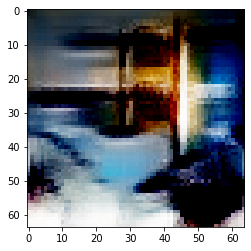

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


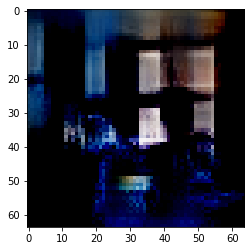

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


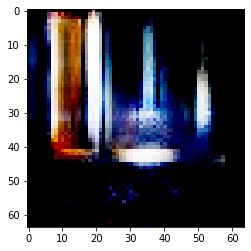

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


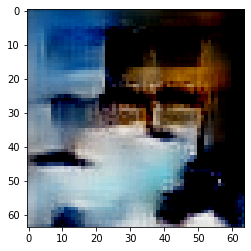

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14


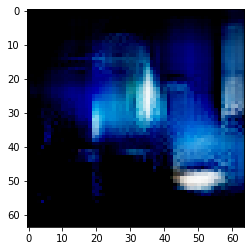

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


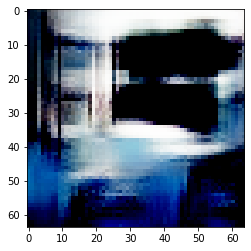

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16


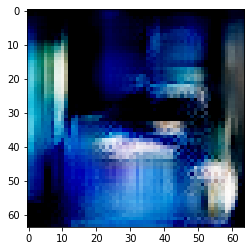

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


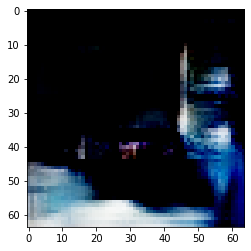

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


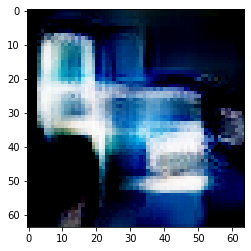

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


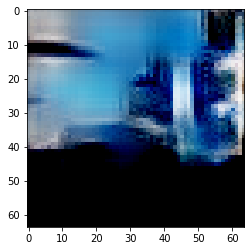

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


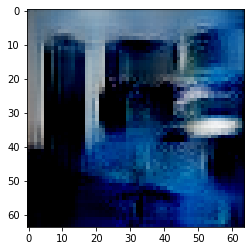

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21


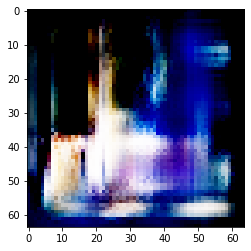

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


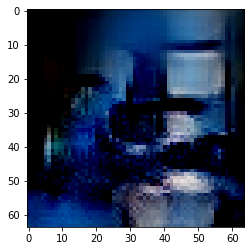

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23


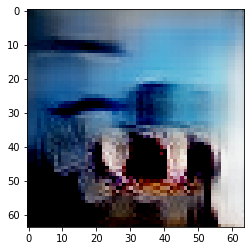

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24


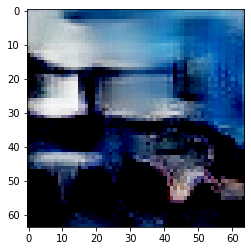

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25


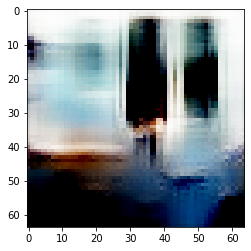

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26


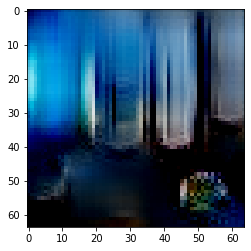

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27


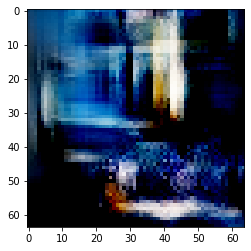

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28


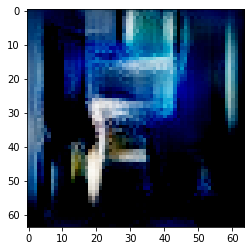

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29


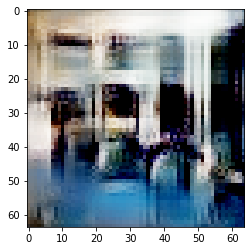

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


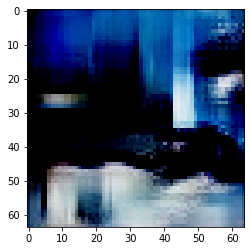

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31


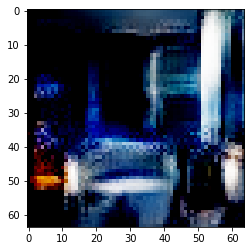

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


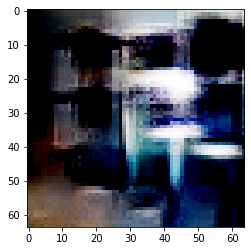

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33


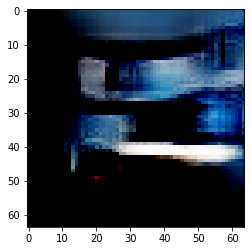

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34


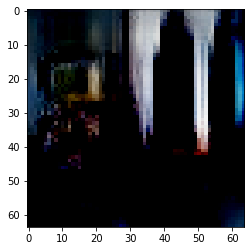

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35


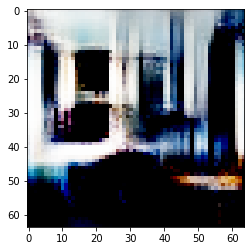

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36


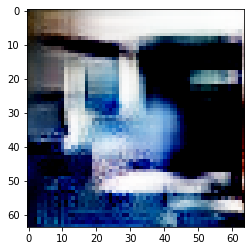

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37


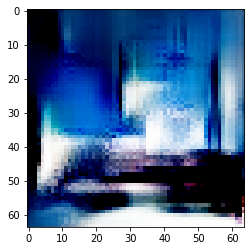

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38


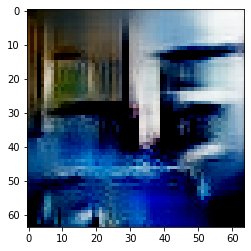

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39


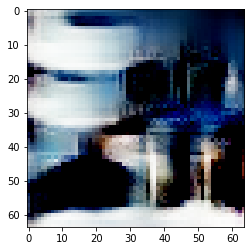

In [24]:
# wgan2-12 images
from matplotlib import pyplot as plt

for i in range(40):
  plt.imshow(fake_images[i], interpolation='nearest')
  print(i)
  plt.show()